In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import torch.nn as nn
import torch
import argparse
import os

import numpy as np

import copy
import torch
from tqdm import tqdm


from tqdm import notebook
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import writer, SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import RandomSampler
from math import pi
import pandas as pd
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import roc_auc_score,average_precision_score,recall_score,precision_score



# from datasets.datasets import Sines
# from models.wgangp import Generator, Critic



# Articles
+ https://arxiv.org/pdf/1803.01271.pdf -TCN
+ https://arxiv.org/pdf/2005.01181.pdf - GAN Forecasting
+ https://papers.nips.cc/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf - TimeGAN (откуда у них реконстрашн лосс?)
+ https://habr.com/ru/post/352794/ gan explained
+ https://habr.com/ru/post/447494/
+ https://www.analyticsvidhya.com/blog/2017/06/introductory-generative-adversarial-networks-gans/ - обучение GAN
+ https://id-lab.ru/posts/developers/sovety-po-obucheniyu-stabilnyh-generativno-sostyazatelnyh-setej-gan/ обучение GAN

1) Как лучше - классификация эмбеддингов, а последовательности отдельно восстанавливать? или сразу генерировать последовательность? Или вектор состояния системы использовать?

2) Двухголовый дискриминатор - хочу чтобы и генератор и дискриминатор могли работать оба с нормальным и аномальным поведением

3) часто читал, что мы пытаемся минимизировать расстояние кульбака лейблера. Но нигде не видел выкладок

4) Цель работы - улучшить бенчмарк? (показать статью) То есть буду стремиться сделать это за счет сэмплинга с помощью ганов

In [ ]:
import pyreadr

normal_train = pyreadr.read_r('dataverse_files/TEP_FaultFree_Training.RData') # also works for Rds
normal_test = pyreadr.read_r('dataverse_files/TEP_FaultFree_Testing.RData')
faulty_train = pyreadr.read_r('dataverse_files/TEP_Faulty_Training.RData')
faulty_test = pyreadr.read_r('dataverse_files/TEP_Faulty_Testing.RData')




In [ ]:
df_n_tr = normal_train['fault_free_training']
df_n_te = normal_test['fault_free_testing']
df_a_tr = faulty_train['faulty_training']
df_a_te = faulty_test['faulty_testing']

In [ ]:
grouped = df_a_tr.groupby(['faultNumber','simulationRun'])

In [ ]:
def get_data(df_n_tr,df_n_te,df_a_tr,df_a_te,seed=1,fault_number=1):
    
    train_normal=df_n_tr[df_n_tr['simulationRun']==seed]
    test_normal=df_n_te[df_n_te['simulationRun']==seed]
    
    train_abnormal=df_a_tr[(df_a_tr['faultNumber']==fault_number)&(df_a_tr['simulationRun']==seed)]
    test_abnormal=df_a_te[(df_a_te['faultNumber']==fault_number)&(df_a_te['simulationRun']==seed)]
    
    return train_normal,test_normal,train_abnormal,test_abnormal
    

In [ ]:
# train_normal,test_normal,train_abnormal,test_abnormal = get_data(df_n_tr,df_n_te,df_a_tr,df_a_te,seed=1,fault_number=1)

In [ ]:
features=['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6',
       'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12',
       'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18',
       'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24',
       'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30',
       'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36',
       'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1',
       'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9',
       'xmv_10', 'xmv_11']

In [ ]:
len(features)

In [ ]:
class MyPrettyDataset(Dataset):
    """The most sexy dataset in the world"""

    def __init__(self, data,sample_len=15):
        
        
        self.features=['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6',
       'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12',
       'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18',
       'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24',
       'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30',
       'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36',
       'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1',
       'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9',
       'xmv_10', 'xmv_11']
        self.data = data
        self.group_size=500
        self.grouped = self.data.groupby(['faultNumber','simulationRun'])
        self.sample_len=sample_len
        self.max_group_index = self.group_size - self.sample_len +1
        self.groups_count = len(self.grouped)
        self.group_keys=list(self.grouped.groups.keys())
        
        self.groups = [self.grouped.get_group(key) for key in self.group_keys  ]
        

    def __len__(self):
        return len(self.grouped)*(self.max_group_index)
    
    def __getitem__(self, idx):
        group_index = idx//(self.max_group_index)
        idx = idx%(self.max_group_index)
        group = self.groups[group_index]#self.grouped.get_group(self.group_keys[group_index])
        
        fault_numbers = group['faultNumber'].unique()

        is_anomal = False
        if len(fault_numbers)>1:
            raise Exception
        elif len(fault_numbers)==1:
            fault = fault_numbers[0]
            if fault >=1:
                is_anomal=1
            else:
                is_anomal=0
        
        return group.iloc[idx:idx+self.sample_len][self.features].values.astype(float),is_anomal
            
        

        

In [ ]:
conc = pd.concat([df_n_tr,df_a_tr[df_a_tr['faultNumber'].isin([1,2,3])]])
# conc = pd.concat([df_n_tr,df_a_tr])

In [ ]:


scaler = MinMaxScaler()
scaler.fit(conc[features].values)
values = scaler.transform(conc[features].values)
conc_scaled = conc.copy()
for i, col in enumerate(features):
    conc_scaled[col] = values[:, i]
conc_scaled.head()

In [ ]:
dataset = MyPrettyDataset(conc_scaled,sample_len=490)

In [ ]:
class Generator(nn.Module):
    def __init__(self,sample_dim,detectors_count=52,hidden_dim=8,label_emb_dim=3,dropout=0.1):
        super().__init__()
        self.label_embedder = nn.Embedding(2,label_emb_dim)
        self.model = nn.Sequential(
                nn.Linear(label_emb_dim+sample_dim+hidden_dim,8),
                nn.BatchNorm1d(8),
                nn.ReLU(),
                nn.Dropout(dropout),
            
                nn.Linear(8, 16),
                nn.BatchNorm1d(16),
                nn.ReLU(),
                nn.Dropout(dropout),
            
                nn.Linear(16, 32),
                nn.BatchNorm1d(32),
                nn.ReLU(),
            
                nn.Linear(32, 52)
        )
    
        self.lstm = nn.LSTM(detectors_count,hidden_dim,batch_first=True,num_layers=2)
        

    def forward(self, timeseries,label,noise):
        
        
        output,hidden = self.lstm(timeseries.float())

        x = output[:,-2,:]
        
        label_embedding = self.label_embedder(label)#.repeat(timeseries.shape[0],1)
        
        x = torch.cat([x,label_embedding,noise],dim=1)

        x = self.model(x)
        
        timeseries[:,-1,:] = x
        return timeseries
    
    



In [ ]:
class Discriminator(nn.Module):
    def __init__(self,detectors_count=52,hidden_dim=8,label_emb_dim=3,dropout=0.1):
        super().__init__()
        
        self.lstm = nn.LSTM(detectors_count,hidden_dim,batch_first=True,num_layers=2)
        self.label_embedder  = nn.Embedding(2,label_emb_dim)
        self.model = nn.Sequential(
                nn.Linear(hidden_dim+label_emb_dim, 32),
                nn.BatchNorm1d(32),
                nn.LeakyReLU(),
                nn.Dropout(dropout),
            
            
                nn.Linear(32, 16),
                nn.BatchNorm1d(16),
                nn.LeakyReLU(),
                nn.Dropout(dropout),
            
                nn.Linear(16, 8),
                nn.BatchNorm1d(8),
                nn.LeakyReLU(),
                nn.Linear(8, 1),
                nn.Sigmoid()
        )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self,input,labels):
        label_embedding = self.label_embedder(labels)
        output,hidden = self.lstm(input.float())
        x = output[:,-1,:]
        x = torch.cat([x,label_embedding],dim=1)
        x = self.model(x)
        return x
    


In [ ]:
len(dataset)

In [ ]:
sampler = RandomSampler(dataset,num_samples=20*10**3,replacement=True)


In [ ]:
from torch.utils.data import WeightedRandomSampler

In [ ]:
def make_weights(dataset,weights_d={0:0.5,1:0.3}):
    weights=[]
    for x,y in notebook.tqdm(dataset):
        weights.append(weights_d[y])
    return weights

In [ ]:
weights = make_weights(dataset)

In [ ]:
sampler = WeightedRandomSampler(weights,num_samples=10**4,replacement=True)

In [ ]:
dataloader = DataLoader(dataset,batch_size=256,num_workers=0,sampler=sampler,drop_last=True)

In [ ]:
for x,y in dataloader:
    print(sum(y))
    break

In [ ]:
NOISE_DIM=8
g = Generator(sample_dim=NOISE_DIM)
d = Discriminator()



g_opt = torch.optim.Adam(g.parameters(), lr = 0.005)

d_opt = torch.optim.Adam(d.parameters(), lr = 0.005) # 



g_loss_f = nn.BCELoss()
d_loss_f = nn.BCELoss()

EPOCHS=10000


PART_OF_SYNTHETIC=2 # поровну 

anomally_label=1
normal_label=0



In [113]:
def log_gradients_in_model(model, logger, step):
    for tag, value in model.named_parameters():
        if value.grad is not None:
#             print(value.grad.cpu())
            logger.add_histogram(model._get_name()+'/'+tag + "/grad", value.grad.cpu(), step)

In [ ]:
writer = SummaryWriter()
for epoch in notebook.tqdm(range(EPOCHS),desc='Epoch'):
    d_sum_loss=0
    g_sum_loss = 0
    for data,anomally_labels in notebook.tqdm(dataloader,desc='Batch'):
        d.train()
        g.train()
        
        # Optimize discriminator
        noise = torch.randn(size=(data.shape[0]//PART_OF_SYNTHETIC,NOISE_DIM))
        idxs = np.random.randint(0, data.shape[0], data.shape[0]//PART_OF_SYNTHETIC)
        is_synthetic_labels=torch.zeros((data.shape[0],1),dtype=torch.float32)
        is_synthetic_labels[idxs]=1
        inverse_synthetic_labels = (is_synthetic_labels+1)%2
        
        with torch.no_grad():
            data[idxs]=g(data[idxs],label=anomally_labels[idxs],noise=noise)
            
        d_output = d(data,labels=anomally_labels)
        
        d_loss = d_loss_f(d_output,is_synthetic_labels) 
        d_sum_loss+=d_loss.item()
        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()
        
        
      
        # Optimize generator
        noise = torch.randn(size=(data.shape[0]//PART_OF_SYNTHETIC,NOISE_DIM))
        idxs = np.random.randint(0, data.shape[0], data.shape[0]//PART_OF_SYNTHETIC)
        
        is_synthetic_labels=torch.zeros((data.shape[0],1),dtype=torch.float32)
        is_synthetic_labels[idxs]=1
        inverse_synthetic_labels = (is_synthetic_labels+1)%2
        
        data[idxs]=g(data[idxs],label=anomally_labels[idxs],noise=noise)
        
        
        d_output = d(data,labels=anomally_labels)
        
        g_loss = g_loss_f(d_output,inverse_synthetic_labels)
        g_sum_loss+=g_loss.item()
        
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
    # Inference discriminator
        
    with torch.no_grad():
        d.eval()
        d_output = d(data,labels=torch.zeros(data.shape[0],dtype=torch.int))
        
        
    # Inference generator
    with torch.no_grad():
        g.eval()
        noise = torch.randn(size=(1,NOISE_DIM))
        idxs = [0]
        fake_data=g(data[idxs],label=anomally_labels[idxs],noise=noise)
    
    log_gradients_in_model(g, writer, epoch)
    log_gradients_in_model(d, writer, epoch)
    writer.add_scalars('Components',
                       {f'Real component':data[0,-1,0].item(),
                        'Synthetic component':fake_data[0,-1,0].item()},
                       epoch)
    writer.add_scalar('Labels count',anomally_labels.sum(),epoch)
    writer.add_scalar('Classification metrics/ROC AUC',roc_auc_score(anomally_labels.numpy(),d_output.numpy(),labels=None),epoch)
    writer.add_scalar('Classification metrics/Recall ',recall_score(anomally_labels.numpy(),(d_output.numpy()>0.5)*1),epoch)
    writer.add_scalar('Classification metrics/Precision ',precision_score(anomally_labels.numpy(),(d_output.numpy()>0.5)*1,zero_division=0),epoch)
    writer.add_scalar('Loss/generator loss',g_sum_loss/len(dataloader),epoch)
    writer.add_scalar('Loss/discriminator loss',d_sum_loss/len(dataloader),epoch)
        
        
        
        


Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

Batch:   0%|          | 0/39 [00:00<?, ?it/s]

# Вопросы:

+ батч нормализация и дропаут
+ как мониторить градиенты? может они очень маленькие?
+ как используется дивергенция?
+ может добавить все таки классификационный лосс?
+ нормальная группировка ранов в тенсорборд
+ клипать градиенты?

In [ ]:
шум не конкатенировать, иначе он его игнорирует 
как используется шум в других моделях?
предсказывать больше точек?
на вход лискриминатору подавать одни и те же иксы, 
добавлять в батч сгенерированные игрики и с теми же иксами

больше точек для предсказания генератором


убедиться, что шум на что то влияет

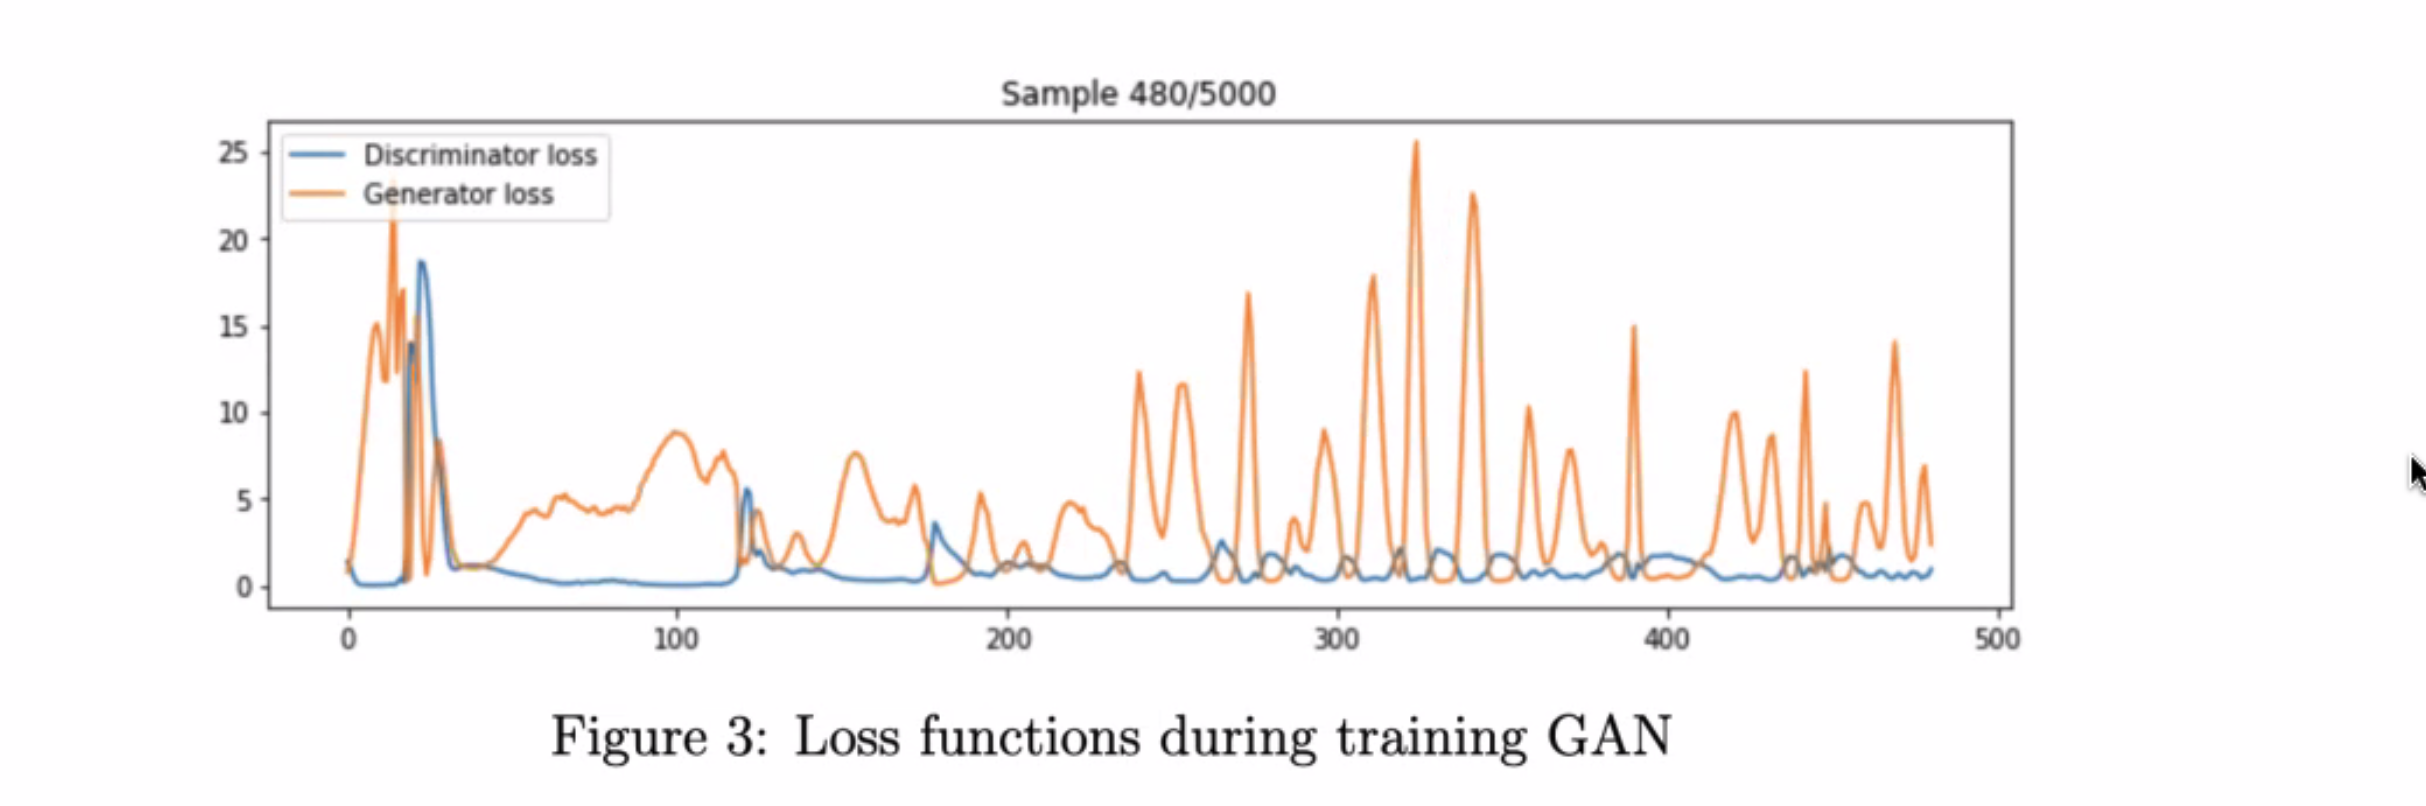